# Exploratory Data Analysis - Airbnb London Dataset

In [2]:
# library
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium.plugins import MarkerCluster
import geopandas as gpd
from shapely.geometry import Point
from itertools import combinations
from collections import Counter
from langdetect import detect, LangDetectException
import numpy as np

## 1. Overview dataset

### 1. Listing data (only apartmen-type)

In [3]:
# Load the CSV file
file_path = 'listings.csv'
df = pd.read_csv(file_path)

# Filter the dataframe to include only rows where 'property_type' contains 'apartment'
apartment_df = df[df['property_type'].str.contains('apartment', case=False, na=False)]

print(apartment_df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 1987 entries, 64 to 90809
Data columns (total 75 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            1987 non-null   int64  
 1   listing_url                                   1987 non-null   object 
 2   scrape_id                                     1987 non-null   int64  
 3   last_scraped                                  1987 non-null   object 
 4   source                                        1987 non-null   object 
 5   name                                          1987 non-null   object 
 6   description                                   1804 non-null   object 
 7   neighborhood_overview                         1230 non-null   object 
 8   picture_url                                   1987 non-null   object 
 9   host_id                                       1987 non-null   int6

### 2. Reviews data (only apartment-type)

In [4]:
file_path = 'reviews.csv'
reviews_df = pd.read_csv(file_path,low_memory=False )
apartment_ids = apartment_df['id']

# Filter the reviews dataframe to include only reviews for the filtered apartment listings
filtered_reviews_df = reviews_df[reviews_df['listing_id'].isin(apartment_ids)]

# Count the number of reviews for the filtered apartment listings
total_reviews = filtered_reviews_df.shape[0]

print(filtered_reviews_df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 33169 entries, 8752 to 1618281
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   listing_id     33169 non-null  int64 
 1   id             33169 non-null  int64 
 2   date           33169 non-null  object
 3   reviewer_id    33169 non-null  int64 
 4   reviewer_name  33169 non-null  object
 5   comments       33162 non-null  object
dtypes: int64(3), object(3)
memory usage: 1.8+ MB
None


### Shape of data

In [5]:
# Print the shape of the filtered_reviews dataframe
print("Shape of filtered_reviews_df :", filtered_reviews_df.shape)

# Print the shape of the apartment_df dataframe
print("Shape of apartment_df :", apartment_df.shape)

Shape of filtered_reviews_df : (33169, 6)
Shape of apartment_df : (1987, 75)


### Date Range of Reviews Dataset

In [6]:
# Create a copy of the dataframe
filtered_reviews_copy = filtered_reviews_df.copy()

# Convert date columns to datetime
filtered_reviews_copy['date'] = pd.to_datetime(filtered_reviews_copy['date'], errors='coerce')

# Find the date range for filtered_reviews
filtered_reviews_date_range = (filtered_reviews_copy['date'].min(), filtered_reviews_copy['date'].max())

# Print the date ranges in a readable format
print(f"Reviews gathered from: {filtered_reviews_date_range[0].strftime('%B %d, %Y')} to {filtered_reviews_date_range[1].strftime('%B %d, %Y')}")

Reviews gathered from: December 29, 2010 to March 21, 2024


### Drop columns which do not contribute much to our data analysis

In [9]:
file_path = 'listings.csv'
df = pd.read_csv(file_path)

# Filter the dataframe to include only rows where 'property_type' contains 'apartment'
apartment_df = df[df['property_type'].str.contains('apartment', case=False, na=False)]

# Columns to drop
columns_to_drop = [
    'listing_url', 'scrape_id', 'last_scraped', 'source', 'picture_url', 
    'host_url', 'host_thumbnail_url', 'host_picture_url', 'host_about', 
    'host_response_time', 'host_response_rate', 'host_acceptance_rate', 
    'host_neighbourhood', 'host_verifications', 'host_has_profile_pic', 
    'host_identity_verified', 'neighbourhood_group_cleansed', 'calendar_updated', 
    'calendar_last_scraped', 'minimum_minimum_nights', 'maximum_minimum_nights', 
    'minimum_maximum_nights', 'maximum_maximum_nights', 'minimum_nights_avg_ntm', 
    'maximum_nights_avg_ntm', 'host_listings_count', 'host_total_listings_count',
    'license','host_location','has_availability','neighbourhood'
]
apartment_df_cleaned = apartment_df.drop(columns=columns_to_drop)

# Rename 'id' column in apartment_data to 'listing_id' for consistency
apartment_df_cleaned.rename(columns={'id': 'listing_id'}, inplace=True)

# Save the cleaned dataframe to a CSV file
apartment_df_cleaned.to_csv('final_apartment_df.csv', index=False)

print("Shape of the cleaned dataframe:", apartment_df_cleaned.shape)
print(apartment_df_cleaned.info())

Shape of the cleaned dataframe: (1987, 44)
<class 'pandas.core.frame.DataFrame'>
Index: 1987 entries, 64 to 90809
Data columns (total 44 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   listing_id                                    1987 non-null   int64  
 1   name                                          1987 non-null   object 
 2   description                                   1804 non-null   object 
 3   neighborhood_overview                         1230 non-null   object 
 4   host_id                                       1987 non-null   int64  
 5   host_name                                     1987 non-null   object 
 6   host_since                                    1987 non-null   object 
 7   host_is_superhost                             1983 non-null   object 
 8   neighbourhood_cleansed                        1987 non-null   object 
 9   latitude               

### Check data type of each dataframe

In [8]:
apartment_df_cleaned_10 = apartment_df_cleaned.copy()
# Convert the price column to numeric (remove any currency symbols and commas)
apartment_df_cleaned_10['price'] = apartment_df_cleaned_10['price'].replace('[\$,]', '', regex=True).astype(float)

# Drop rows with NaN values in the 'price' column
apartment_df_cleaned_10 = apartment_df_cleaned_10.dropna(subset=['price'])

# Calculate the 99.7th percentile
percentile_997 = apartment_df_cleaned_10['price'].quantile(0.997)
percentile_997

2435.3899999999758

In [9]:
filtered_reviews_df_dtypes = filtered_reviews_df.dtypes
filtered_reviews_df_dtypes

listing_id        int64
id                int64
date             object
reviewer_id       int64
reviewer_name    object
comments         object
dtype: object

## Check missing value

### 1. Listings

In [10]:
missing_values_apartment = apartment_df_cleaned.isnull().sum()
missing_values_apartment

listing_id                                        0
name                                              0
description                                     183
neighborhood_overview                           757
host_id                                           0
host_name                                         0
host_since                                        0
host_is_superhost                                 4
neighbourhood_cleansed                            0
latitude                                          0
longitude                                         0
property_type                                     0
room_type                                         0
accommodates                                      0
bathrooms                                       272
bathrooms_text                                   12
bedrooms                                         15
beds                                            274
amenities                                         0
price       

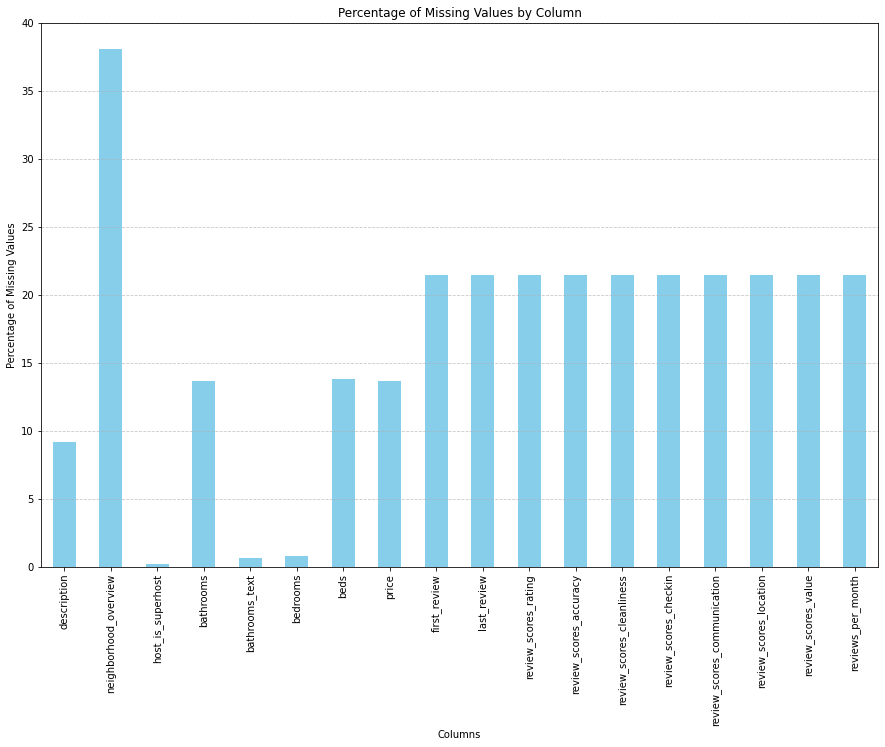

In [11]:
# Calculate the percentage of missing values for each column
missing_percentage = apartment_df_cleaned.isnull().mean() * 100

# Filter out columns with no missing values
missing_percentage = missing_percentage[missing_percentage > 0]

# Plot the missing values as a bar chart
plt.figure(figsize=(15, 10))
missing_percentage.plot(kind='bar', color='skyblue')
plt.title('Percentage of Missing Values by Column')
plt.xlabel('Columns')
plt.ylabel('Percentage of Missing Values')
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [12]:
# Replace missing values with 'Not provided' using .loc
apartment_df_cleaned.loc[apartment_df['description'].isnull(), 'description'] = 'Not provided'
apartment_df_cleaned.loc[apartment_df['neighborhood_overview'].isnull(), 'neighborhood_overview'] = 'Not provided'
apartment_df_cleaned.loc[apartment_df['host_is_superhost'].isnull(), 'host_is_superhost'] = 'Not provided'

# Verify the replacements
missing_values_after_replacement = apartment_df_cleaned[['description', 'neighborhood_overview', 'host_is_superhost']].isnull().sum()
print("Missing values after replacement:\n", missing_values_after_replacement)


Missing values after replacement:
 description              0
neighborhood_overview    0
host_is_superhost        0
dtype: int64


In [13]:
# Anonymize host names
unique_host_names = apartment_df_cleaned['host_name'].unique()
host_name_mapping = {name: f'host_{str(i).zfill(3)}' for i, name in enumerate(unique_host_names)}
apartment_df_cleaned['host_name'] = apartment_df_cleaned['host_name'].map(host_name_mapping)

# Save the anonymized DataFrame
anonymized_file_path = 'final_apartment_df.csv'  # Specify your desired output file path
apartment_df_cleaned.to_csv(anonymized_file_path, index=False)

print("Host names have been anonymized and the updated file has been saved.")

# Display the first few rows of the updated DataFrame
print(apartment_df_cleaned.head())

Host names have been anonymized and the updated file has been saved.
     listing_id                                          name  \
64        49970            Beautiful Small Studio Hammersmith   
114       81080             Luxury Self contained Studio Apt.   
205      282198               Georgian Aparment in Bloomsbury   
812      680656  Modern Triple Studio  Zone 2 Hammersmith (5)   
843      726882                West Kensington central London   

                                           description  \
64                                        Not provided   
114  Perfect Studio apartment with separate kitchen...   
205                                       Not provided   
812  Comfortable Studio for 3 persons 1 x double be...   
843  Lovely spacious double room with lots of stora...   

                                 neighborhood_overview  host_id host_name  \
64                                        Not provided   216660  host_000   
114  Lots of local history - you are 

In [14]:
missing_values_reviews = filtered_reviews_df.isnull().sum()
missing_values_reviews

listing_id       0
id               0
date             0
reviewer_id      0
reviewer_name    0
comments         7
dtype: int64

In [15]:
# Replace missing comments with 'no comment' using .loc 
filtered_reviews_df.loc[filtered_reviews_df['comments'].isnull(), 'comments'] = 'no comment'

# Verify the replacement
missing_values_reviews_after = filtered_reviews_df.isnull().sum()
print("\nMissing values after replacement:")
print(missing_values_reviews_after)


Missing values after replacement:
listing_id       0
id               0
date             0
reviewer_id      0
reviewer_name    0
comments         0
dtype: int64


from 'filtered_reviews.csv' >  'cleaned_test1.csv' 

## Distribution of language

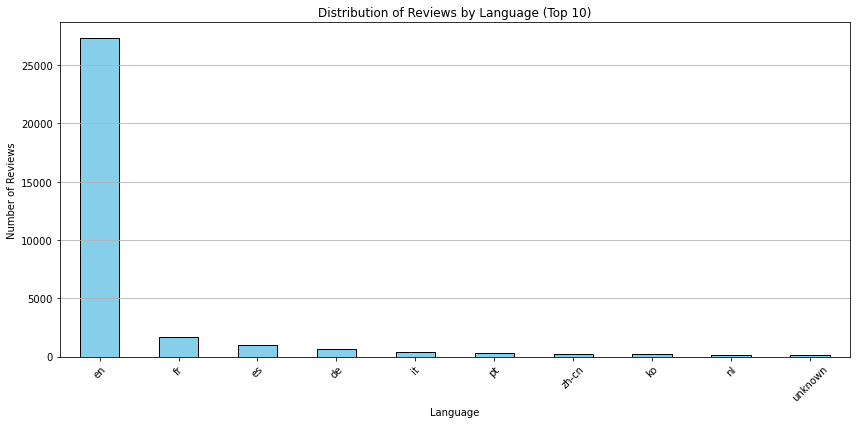

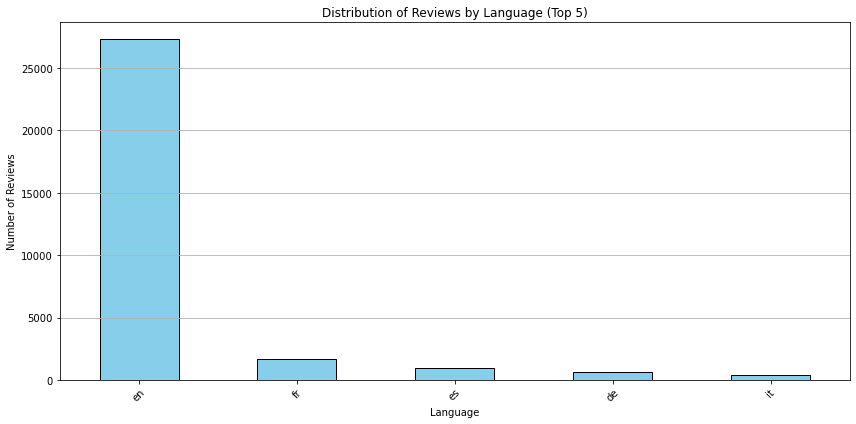

In [17]:
# Load the filtered reviews dataset
language_reviews_path = 'cleaned_test1.csv'
language_reviews_df = pd.read_csv(language_reviews_path)

# Strip leading/trailing spaces from column names
language_reviews_df.columns = language_reviews_df.columns.str.strip()

# Ensure all comments are strings
language_reviews_df['comments'] = language_reviews_df['comments'].astype(str)

# Function to detect language with exception handling
def safe_detect_language(text):
    try:
        return detect(text)
    except LangDetectException:
        return 'unknown'

# Detect the language for each review
language_reviews_df['language'] = language_reviews_df['comments'].apply(safe_detect_language)

# Analyze the number of languages and the number of reviews in each language
language_distribution = language_reviews_df['language'].value_counts()

# Plot the language distribution for top 10 languages
top_10_languages = language_distribution.head(10)
plt.figure(figsize=(12, 6))
top_10_languages.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Distribution of Reviews by Language (Top 10)')
plt.xlabel('Language')
plt.ylabel('Number of Reviews')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# Plot the language distribution for top 5 languages
top_5_languages = language_distribution.head(5)
plt.figure(figsize=(12, 6))
top_5_languages.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Distribution of Reviews by Language (Top 5)')
plt.xlabel('Language')
plt.ylabel('Number of Reviews')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

*en = English, fr = France, es = Spanish, de = German, it = Italy



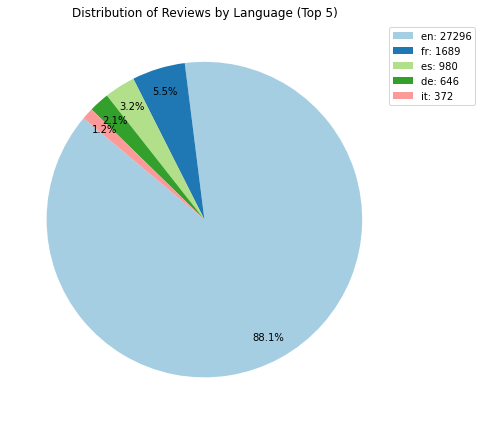

In [18]:
# Get the top 5 languages
top_5_languages = language_distribution.head(5)

# Define a color palette
colors = plt.cm.Paired(range(len(top_5_languages)))

# Create a pie chart
plt.figure(figsize=(10, 6))
wedges, texts, autotexts = plt.pie(
    top_5_languages,
    autopct='%1.1f%%',
    startangle=140,
    colors=colors,
    pctdistance=0.85
)

# Add count labels
for i, (text, autotext) in enumerate(zip(texts, autotexts)):
    text.set_text('')
    autotext.set_text(f'{autotext.get_text()}')

# Add a legend in the top right corner
plt.legend(
    labels=[f'{lang}: {count}' for lang, count in zip(top_5_languages.index, top_5_languages)],
    loc='upper right',
    bbox_to_anchor=(1.2, 1)
)

# Add a title
plt.title('Distribution of Reviews by Language (Top 5)')
plt.tight_layout()

# Show the plot
plt.show()

In [19]:
# Analyze the number of languages and the number of reviews in each language
language_distribution = language_reviews_df['language'].value_counts()

# Display the language distribution
print(language_distribution)

language
en         27296
fr          1689
es           980
de           646
it           372
pt           309
zh-cn        268
ko           196
nl           152
unknown      143
ro           131
so           105
pl            82
sv            79
af            76
ca            68
ar            64
no            54
cs            50
da            48
he            42
fi            32
tl            30
ja            27
tr            26
sw            25
ru            24
zh-tw         23
hu            20
cy            17
hr            17
el            15
id            13
et            12
sk            12
sl             5
lt             5
vi             4
th             4
uk             3
bg             2
ur             1
sq             1
fa             1
Name: count, dtype: int64


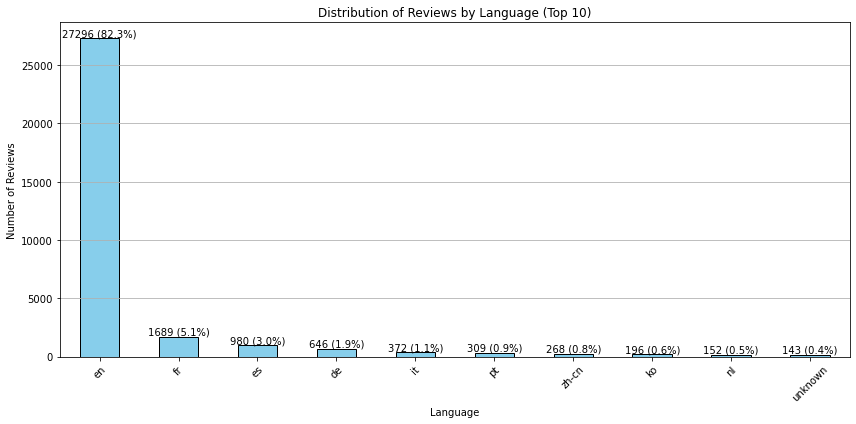

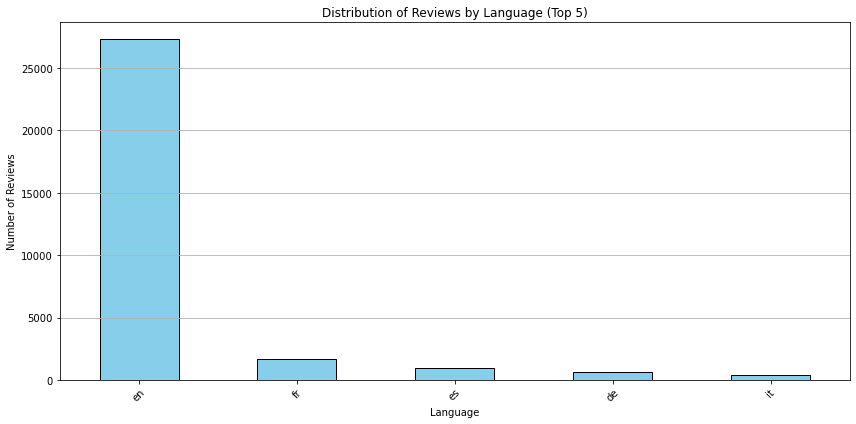

In [39]:
# Analyze the number of languages and the number of reviews in each language
language_distribution = language_reviews_df['language'].value_counts()

# Analyze the number of languages and the number of reviews in each language
language_distribution = language_reviews_df['language'].value_counts()

# Plot the language distribution for top 10 languages
top_10_languages = language_distribution.head(10)

# Calculate the total number of reviews
total_reviews = language_reviews_df.shape[0]

# Calculate the percentage for each language in the top 10
percentages = (top_10_languages / total_reviews) * 100

# Plotting the bar chart
plt.figure(figsize=(12, 6))
ax = top_10_languages.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Distribution of Reviews by Language (Top 10)')
plt.xlabel('Language')
plt.ylabel('Number of Reviews')
plt.xticks(rotation=45)
plt.grid(axis='y')

# Add annotations for percentages
for i in ax.patches:
    percentage = (i.get_height() / total_reviews) * 100
    ax.annotate(f'{i.get_height()} ({percentage:.1f}%)', 
                (i.get_x() + i.get_width() / 2, i.get_height()), 
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5), 
                textcoords='offset points')

plt.tight_layout()
plt.show()

# Plot the language distribution for top 5 languages
top_5_languages = language_distribution.head(5)
plt.figure(figsize=(12, 6))
top_5_languages.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Distribution of Reviews by Language (Top 5)')
plt.xlabel('Language')
plt.ylabel('Number of Reviews')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

### UK vs US English distribution

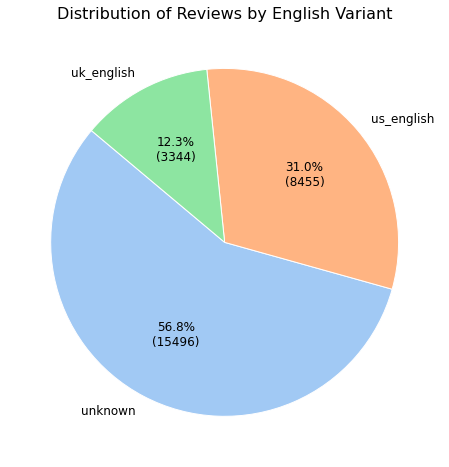

english_variant
unknown       15496
us_english     8456
uk_english     3344
Name: count, dtype: int64


In [21]:
# US vs UK English Detection using keyword-based approach / add more slang
us_english_keywords = {'color', 'honor', 'center', 'analyze', 'theater',
                       'flavor', 'neighbor', 'traveled', 'license', 'gray',
                       'defense', 'offense', 'practice', 'program', 'check',
                       'airplane', 'truck', 'cookie', 'awesome', 'trash', 
                       'elevator', 'sidewalk', 'gasoline', 'apartment', 
                       'candy', 'cellphone', 'diaper', 'fall', 'faucet', 
                       'flashlight', 'fries', 'mailbox', 'movie', 'sneakers'}

uk_english_keywords = {'colour', 'honour', 'centre', 'analyse', 'theatre',
                       'flavour', 'neighbour', 'travelled', 'licence', 'grey',
                       'defence', 'offence', 'practise', 'programme', 'cheque',
                       'aeroplane', 'lorry', 'biscuit', 'brilliant', 'rubbish', 
                       'lift', 'pavement', 'petrol', 'flat', 'sweets', 
                       'mobile', 'nappy', 'autumn', 'tap', 'torch', 'chips', 
                       'postbox', 'film', 'trainers'}

def detect_english_variant(text):
    us_count = sum([1 for word in us_english_keywords if word in text])
    uk_count = sum([1 for word in uk_english_keywords if word in text])
    
    if us_count > uk_count:
        return 'us_english'
    elif uk_count > us_count:
        return 'uk_english'
    else:
        return 'unknown'

# Filter English reviews
english_reviews_df = language_reviews_df[language_reviews_df['language'] == 'en'].copy()

# Detect English variants
english_reviews_df.loc[:, 'english_variant'] = english_reviews_df['comments'].apply(detect_english_variant)

# Analyze the number of reviews in each English variant
english_variant_distribution = english_reviews_df['english_variant'].value_counts()

# Plot the English variant distribution as a pie chart
plt.figure(figsize=(8, 8))
colors = sns.color_palette("pastel")

# Calculate percentages
percentages = english_variant_distribution / english_variant_distribution.sum() * 100

# Create pie chart
wedges, texts, autotexts = plt.pie(
    english_variant_distribution,
    labels=english_variant_distribution.index,
    colors=colors,
    autopct=lambda pct: f'{pct:.1f}%\n({int(pct*sum(english_variant_distribution)/100)})',
    startangle=140,
    wedgeprops=dict(edgecolor='w')
)

# Customize text properties
for text in texts:
    text.set_fontsize(12)
    text.set_color('black')

for autotext in autotexts:
    autotext.set_fontsize(12)
    autotext.set_color('black')

plt.title('Distribution of Reviews by English Variant', fontsize=16)
plt.show()

# Analyze the number of reviews in each English variant
english_variant_distribution = english_reviews_df['english_variant'].value_counts()
print(english_variant_distribution)

## Discover the cultural in French 
- differentiate French whether comes from which country

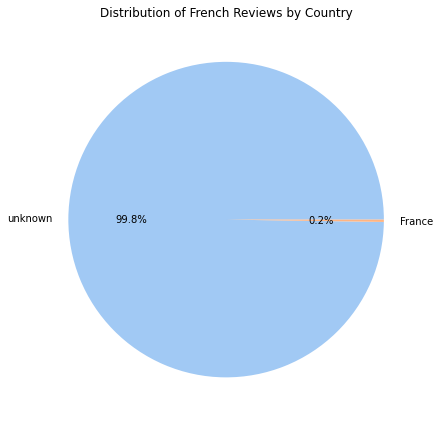

country
unknown    1688
France        4
Name: count, dtype: int64


In [22]:
import pandas as pd
import re
from langdetect import detect, LangDetectException
import matplotlib.pyplot as plt
import seaborn as sns

# Load the filtered reviews dataset
language_reviews_path = 'cleaned_test1.csv'
language_reviews_df_5 = pd.read_csv(language_reviews_path)

# Strip leading/trailing spaces from column names
language_reviews_df_5.columns = language_reviews_df_5.columns.str.strip()

# Ensure all comments are strings
language_reviews_df_5['comments'] = language_reviews_df_5['comments'].astype(str)

# Function to detect language with exception handling
def safe_detect_language(text):
    try:
        return detect(text)
    except LangDetectException:
        return 'unknown'

# Detect the language for each review
language_reviews_df_5['language'] = language_reviews_df_5['comments'].apply(safe_detect_language)

# Analyze the number of languages and the number of reviews in each language
language_distribution = language_reviews_df_5['language'].value_counts()

# List of French-speaking countries with associated keywords
french_keywords = {
    'France': ['paris', 'marseille', 'lyon', 'france'],
    'Canada': ['montreal', 'quebec', 'canada'],
    'Belgium': ['brussels', 'antwerp', 'belgium'],
    'Switzerland': ['geneva', 'zurich', 'switzerland'],
    'Luxembourg': ['luxembourg'],
    'Senegal': ['dakar', 'senegal'],
    'Ivory Coast': ['abidjan', 'ivory coast', 'côte d\'ivoire'],
    # Add more countries and keywords as needed
}

# Function to detect the country based on keywords
def detect_french_speaking_country(text):
    text = text.lower()
    for country, keywords in french_keywords.items():
        if any(keyword in text for keyword in keywords):
            return country
    return 'unknown'

# Filter French reviews
french_reviews_df = language_reviews_df_5[language_reviews_df_5['language'] == 'fr'].copy()

# Detect French-speaking country
french_reviews_df['country'] = french_reviews_df['comments'].apply(detect_french_speaking_country)

# Analyze the number of reviews in each French-speaking country
french_country_distribution = french_reviews_df['country'].value_counts()

# Plot the French-speaking country distribution
plt.figure(figsize=(12, 6))
french_country_distribution.plot(kind='pie', autopct='%1.1f%%', colors=sns.color_palette('pastel'))
plt.title('Distribution of French Reviews by Country')
plt.ylabel('')
plt.tight_layout()
plt.show()

# Display the distribution
print(french_country_distribution)


To analyze the cultural context of languages like French, which is spoken in multiple countries, we can incorporate geolocation information if available in the dataset. However, the dataset does not contain explicit location information (user profile, location tags), using other metadata such as user profiles or specific keywords and phrases commonly associated with different French-speaking regions.

**Data preprocessing for 'reviews.csv' > 'spelling_corrected_reviews.csv'**

* for preprocessing step, these steps done by using VS code.
- test4.py - translate non-English comment
- test7.py - problem with chinese language from test4.py so this file will re-translate again.
- test9.py - still have some problem with test7.py, so this fill re-translate with another approach.
- test10.py - translate success but have some problem with indexing, this file is introduced to solve the index issue.
- cleaned_reviews.py - convert all reviews to lower case and remove punctuation
- spell_checker.py - spelling checker via Spellchecker python library and save to the file 'spelling_corrected_reviews' 

Remark : This will be further discussed in Appendix part

In [23]:
# Define the path to your CSV file
file_path = 'spelling_corrected_reviews.csv'

# Read the CSV file into a DataFrame
final_reviews_df = pd.read_csv(file_path,low_memory=False )

print(final_reviews_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33169 entries, 0 to 33168
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0    listing_id    33169 non-null  int64 
 1   id             33169 non-null  int64 
 2   date           33169 non-null  object
 3   reviewer_id    33169 non-null  int64 
 4   reviewer_name  33169 non-null  object
 5   comments       33169 non-null  object
 6   language       33169 non-null  object
dtypes: int64(3), object(4)
memory usage: 1.8+ MB
None


**Descriptive Statistics:**

- The dataset contains 33,169 reviews.
- There are 33,169 unique reviewer names.
- Most reviews are in English (en), accounting for 31,894 reviews.
- The comments column has a high number of unique entries (31,726), with "no comment" being the most frequent non-unique entry (94 occurrences).


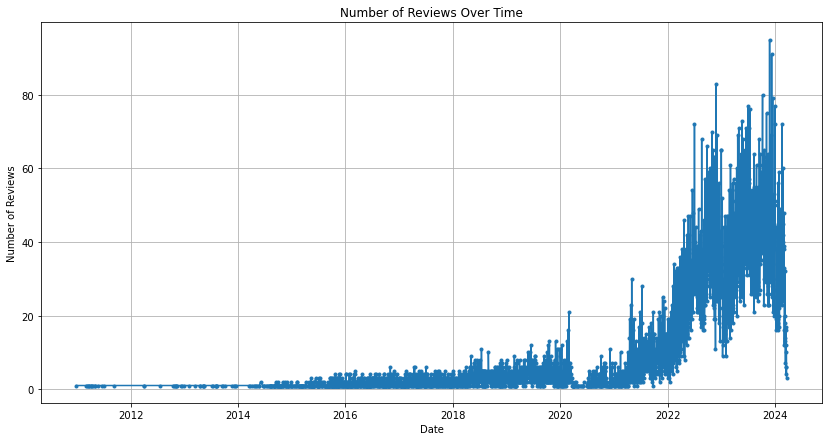

In [26]:
# Convert the 'date' column to datetime format if it's not already
final_reviews_df['date'] = pd.to_datetime(final_reviews_df['date'])

# Plot the distribution of reviews over time
reviews_per_date = final_reviews_df['date'].value_counts().sort_index()

plt.figure(figsize=(14, 7))
plt.plot(reviews_per_date.index.to_numpy(), reviews_per_date.values, marker='o', linestyle='-', markersize=3)
plt.title('Number of Reviews Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Reviews')
plt.grid(True)
plt.show()


### Top 10 Listings 

In [33]:
final_reviews_df.columns = final_reviews_df.columns.str.strip()
apartment_df_cleaned.columns = apartment_df_cleaned.columns.str.strip()

# Merge the reviews data with the apartment details to get listing names
merged_data = pd.merge(final_reviews_df, apartment_df_cleaned, on='listing_id', how='left')

# Identify listings with the most reviews
reviews_per_listing = merged_data.groupby(['listing_id', 'name']).size().sort_values(ascending=False).head(10)
top_listings = reviews_per_listing.reset_index()
top_listings.columns = ['listing_id', 'name', 'number_of_reviews']

# Display the top listings with their names and number of reviews without the index
print(top_listings.to_string(index=False))


        listing_id                                               name  number_of_reviews
          10857242                   Nice room in the heart of London                331
            726882                     West Kensington central London                303
          47828503                           The Terrace Soho gardens                274
          26277526 Bikki apartments / 2 bed / 20 mins to Baker Street                271
          52111380                         Spacious Studio Apartments                258
           8728268 Cosy Two Bed Apartment- Edgware Road - Marble Arch                241
          48524900       60a Apartment @ The Somers Town Coffee House                218
          39798147          Standard Studio Apartment for city breaks                211
          25610130     Double Room To Rent In Flat In Central Hackney                205
567098117232683089         The Chaplin Room: Historic Design-led Stay                197


The time series plot shows the number of reviews over time, highlighting trends, seasonality, and any significant spikes or drops in review activity.

## 2. Data Distribution

## 2.1 Univariate Analysis
- analyse data over single variable/column from dataset

### 2.1.1 Numerical Data Distributions

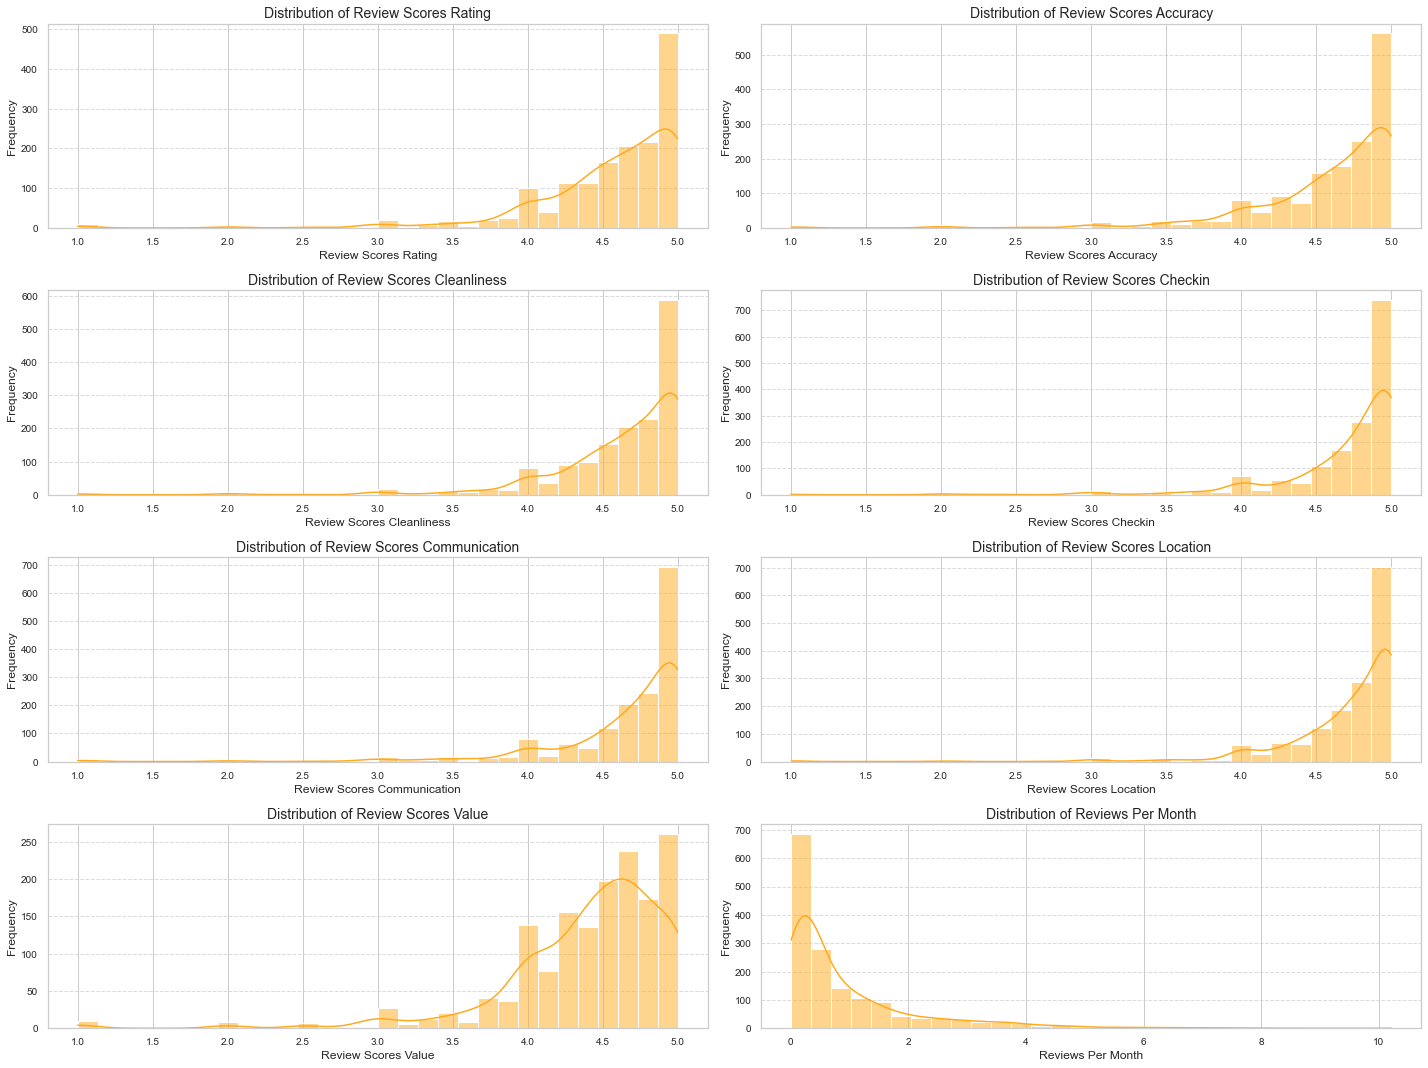

In [10]:
# Define the columns to plot
columns_to_plot = [
    'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness',
    'review_scores_checkin', 'review_scores_communication', 'review_scores_location',
    'review_scores_value', 'reviews_per_month'
]

# Set up the plotting environment
plt.figure(figsize=(20, 15))
sns.set(style="whitegrid")

# Plot each column
for i, column in enumerate(columns_to_plot, 1):
    plt.subplot(4, 2, i)
    sns.histplot(apartment_df_cleaned[column], bins=30, kde=True, color='#FFAA1D')
    plt.title(f'Distribution of {column.replace("_", " ").title()}', fontsize=14)
    plt.xlabel(column.replace("_", " ").title(), fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)

plt.tight_layout()
plt.show()


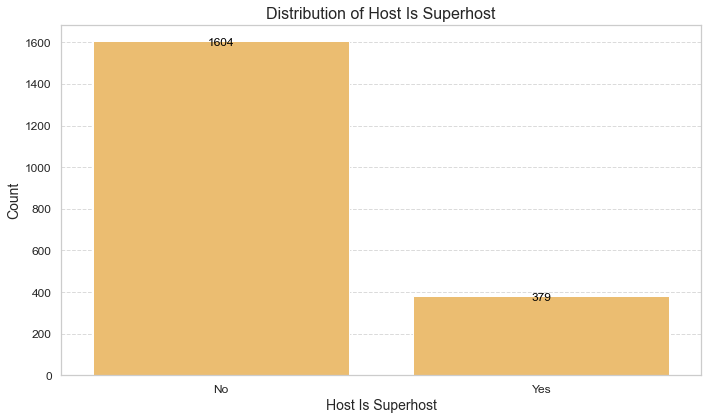

In [32]:
# Make a copy of the dataframe to avoid modifying the original
apartment_df_copy = apartment_df_cleaned.copy()

# Replace 'f' with 'No' and 't' with 'Yes'
apartment_df_copy['host_is_superhost'] = apartment_df_copy['host_is_superhost'].replace({'f': 'No', 't': 'Yes'})

# Drop rows where 'host_is_superhost' is 'Not provided'
apartment_df_copy = apartment_df_copy[apartment_df_copy['host_is_superhost'] != 'Not provided']

# Set up the plotting environment
plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")

# Bar chart for host_is_superhost
ax = sns.countplot(x=apartment_df_copy['host_is_superhost'], palette=['#FFC25D'])
plt.title('Distribution of Host Is Superhost', fontsize=16)
plt.xlabel('Host Is Superhost', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Add annotations
for p in ax.patches:
    ax.annotate(f'\n{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                 ha='center', va='center', fontsize=12, color='black', xytext=(0, 5), 
                 textcoords='offset points')

plt.tight_layout()
plt.show()

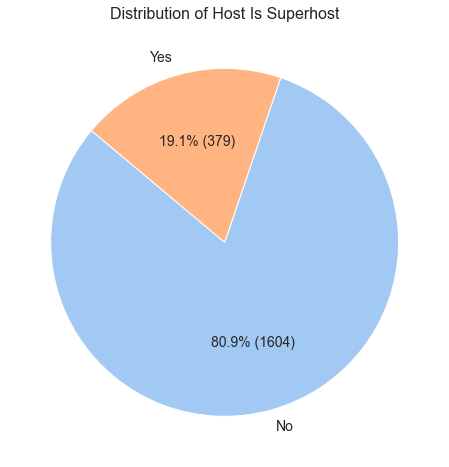

In [33]:
# Calculate the distribution of host_is_superhost
superhost_counts = apartment_df_copy['host_is_superhost'].value_counts()
superhost_labels = superhost_counts.index
superhost_values = superhost_counts.values

# Calculate percentages
superhost_percentages = 100 * superhost_values / superhost_values.sum()

# Create pie chart
plt.figure(figsize=(8, 8))
colors = sns.color_palette('pastel')[0:2]  # Using a pastel color palette
plt.pie(superhost_values, labels=superhost_labels, autopct=lambda p: f'{p:.1f}% ({int(round(p*sum(superhost_values)/100.0))})', colors=colors, startangle=140, textprops={'fontsize': 14})

plt.title('Distribution of Host Is Superhost', fontsize=16)
plt.show()

#### Defintion

1. **Host** is anyone who lists their property (or a room within their property) on the platform for guests to book. 

2. **Superhost** a host who has consistently provided exceptional hospitality and met specific criteria set by Airbnb. 

- Completed at least 10 trips or 3 reservations that total at least 100 nights: This shows they have a good track record of hosting guests.
- Maintained a 90% response rate or higher: This indicates they are responsive to inquiries and concerns.
- Maintained a less than 1% cancellation rate: This demonstrates reliability and commitment to hosting.
- Maintained a 4.8 overall rating: This reflects high guest satisfaction with their hosting experience.

(Airbnb,n.d.)

### 2.1.2 Numerical features

#### Summary of Prices Grouped by Neighborhood

In [30]:
# Make a copy of the dataframe to avoid modifying the original
apartment_df_copy_price = apartment_df_cleaned.copy()

# Convert the price column to numeric (remove any currency symbols and commas)
apartment_df_copy_price['price'] = apartment_df_copy_price['price'].replace('[\$,]', '', regex=True).astype(float)

# Drop rows with NaN values in the 'price' column
apartment_df_copy_price = apartment_df_copy_price.dropna(subset=['price'])

# Calculate statistical summary of price grouped by 'neighbourhood_cleansed'
neighborhood_stats = apartment_df_copy_price.groupby('neighbourhood_cleansed')['price'].describe()

# Calculate overall mean and median price
overall_mean_price = apartment_df_copy_price['price'].mean()
overall_median_price = apartment_df_copy_price['price'].median()

# Display the statistical summary
print("Statistical Summary of Prices Grouped by Neighborhood:")
print(neighborhood_stats)

# Display overall mean and median price
print(f"\nOverall Mean Price: ${overall_mean_price:.2f}")
print(f"Overall Median Price: ${overall_median_price:.2f}")

Statistical Summary of Prices Grouped by Neighborhood:
                        count        mean          std    min     25%    50%  \
neighbourhood_cleansed                                                         
Barking and Dagenham      9.0  159.666667    82.828135   40.0  114.00  155.0   
Barnet                   35.0  127.371429    43.913073   74.0  108.00  112.0   
Bexley                    5.0  134.800000   112.029907   50.0   69.00   89.0   
Brent                    32.0  166.093750    76.768340   45.0  109.50  163.0   
Bromley                   9.0   91.666667    48.994898   55.0   58.00   65.0   
Camden                  139.0  228.460432   121.288509   65.0  152.00  190.0   
City of London           60.0  197.583333    44.689623  108.0  170.00  200.0   
Croydon                  20.0  123.550000    43.500121   54.0   93.75  122.0   
Ealing                   18.0  154.666667   120.047050   60.0   86.25  132.0   
Enfield                  12.0  124.000000    59.185379   41.0   8

In [40]:
# Make a copy of the dataframe to avoid modifying the original
apartment_df_copy_price = apartment_df_cleaned.copy()

# Convert the price column to numeric (remove any currency symbols and commas)
apartment_df_copy_price['price'] = apartment_df_copy_price['price'].replace('[\$,]', '', regex=True).astype(float)

# Drop rows with NaN values in the 'price' column
apartment_df_copy_price = apartment_df_copy_price.dropna(subset=['price'])

# Calculate overall statistical summary of price
overall_stats = apartment_df_copy_price['price'].describe()

# Calculate overall mean and median price
overall_mean_price = apartment_df_copy_price['price'].mean()
overall_median_price = apartment_df_copy_price['price'].median()

# Display the overall statistical summary
print("Overall Statistical Summary of Prices:")
print(overall_stats)

# Display overall mean and median price
print(f"\nOverall Mean Price: ${overall_mean_price:.2f}")
print(f"Overall Median Price: ${overall_median_price:.2f}")

Overall Statistical Summary of Prices:
count     1715.000000
mean       267.029738
std        542.243922
min         36.000000
25%        134.000000
50%        194.000000
75%        295.000000
max      20000.000000
Name: price, dtype: float64

Overall Mean Price: $267.03
Overall Median Price: $194.00


<Figure size 1008x720 with 0 Axes>

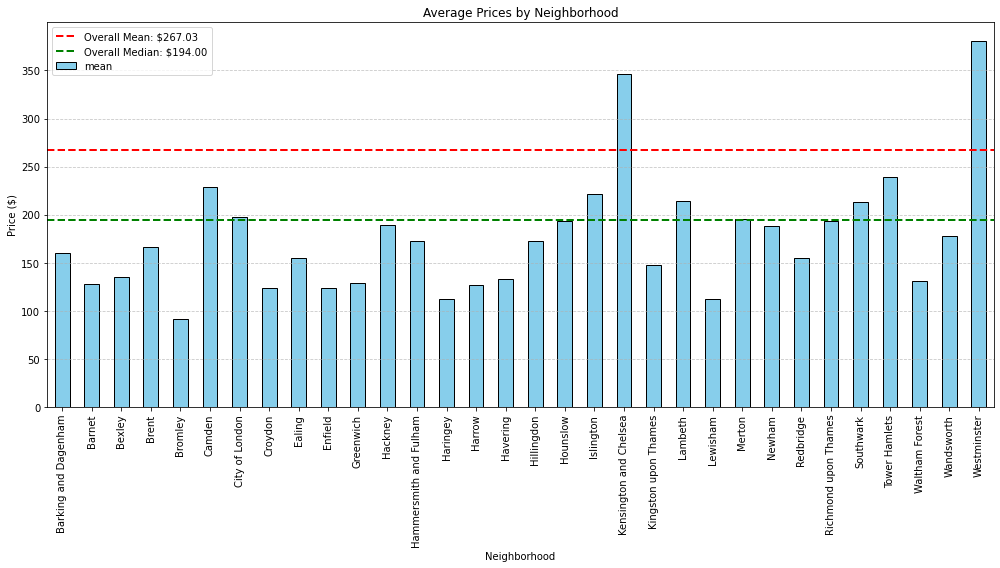

In [42]:
# Make a copy of the dataframe to avoid modifying the original
apartment_df_copy_price = apartment_df_cleaned.copy()

# Convert the price column to numeric (remove any currency symbols and commas)
apartment_df_copy_price['price'] = apartment_df_copy_price['price'].replace('[\$,]', '', regex=True).astype(float)

# Drop rows with NaN values in the 'price' column
apartment_df_copy_price = apartment_df_copy_price.dropna(subset=['price'])

# Calculate statistical summary of price grouped by 'neighbourhood_cleansed'
neighborhood_stats = apartment_df_copy_price.groupby('neighbourhood_cleansed')['price'].describe()

# Calculate overall mean and median price
overall_mean_price = apartment_df_copy_price['price'].mean()
overall_median_price = apartment_df_copy_price['price'].median()

# Plot the statistical summary
plt.figure(figsize=(14, 10))

# Mean prices by neighborhood
plt.figure(figsize=(14, 8))
ax = neighborhood_stats['mean'].plot(kind='bar', color='skyblue', edgecolor='black')
plt.axhline(overall_mean_price, color='red', linestyle='--', linewidth=2, label=f'Overall Mean: ${overall_mean_price:.2f}')
plt.axhline(overall_median_price, color='green', linestyle='--', linewidth=2, label=f'Overall Median: ${overall_median_price:.2f}')
plt.title('Average Prices by Neighborhood')
plt.xlabel('Neighborhood')
plt.ylabel('Price ($)')
ax.set_xticklabels(neighborhood_stats.index, rotation=90)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### 2.1.3 Categorical Ordered Univariate Analysis

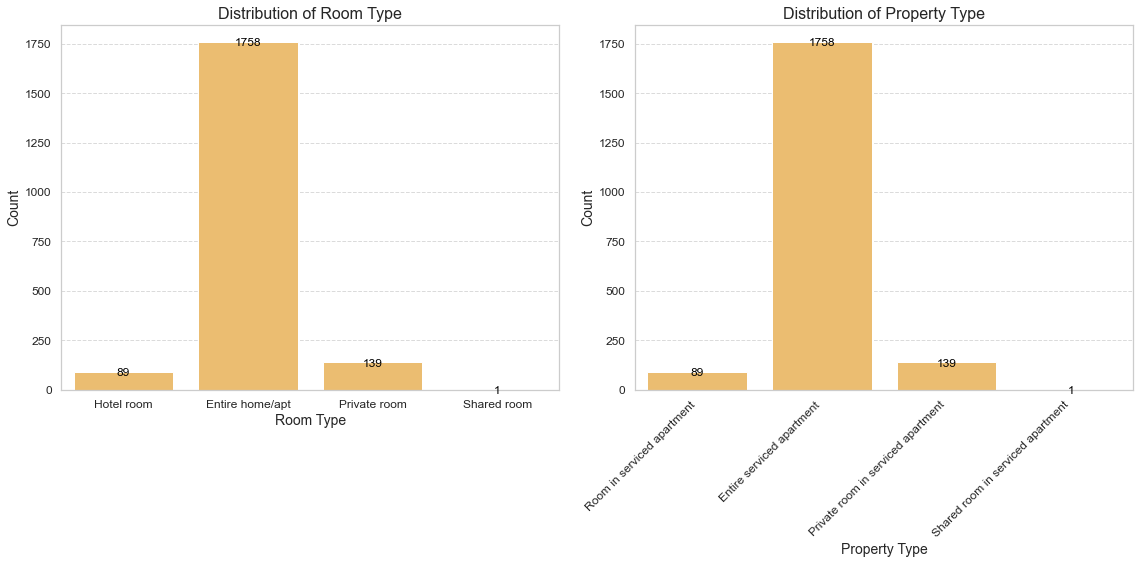

In [21]:
# Set up the plotting environment
plt.figure(figsize=(16, 8))
sns.set(style="whitegrid")

# Bar chart for room type
plt.subplot(1, 2, 1)
ax1 = sns.countplot(x=apartment_df_cleaned['room_type'], palette=['#FFC25D'])
plt.title('Distribution of Room Type', fontsize=16)
plt.xlabel('Room Type', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Add annotations
for p in ax1.patches:
    ax1.annotate(f'\n{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                 ha='center', va='center', fontsize=12, color='black', xytext=(0, 5), 
                 textcoords='offset points')

# Bar chart for property type
plt.subplot(1, 2, 2)
ax2 = sns.countplot(x=apartment_df_cleaned['property_type'], palette=['#FFC25D'])
plt.title('Distribution of Property Type', fontsize=16)
plt.xlabel('Property Type', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(fontsize=12, rotation=45, ha='right')
plt.yticks(fontsize=12)

# Add annotations
for p in ax2.patches:
    ax2.annotate(f'\n{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                 ha='center', va='center', fontsize=12, color='black', xytext=(0, 5), 
                 textcoords='offset points')

plt.tight_layout()
plt.show()


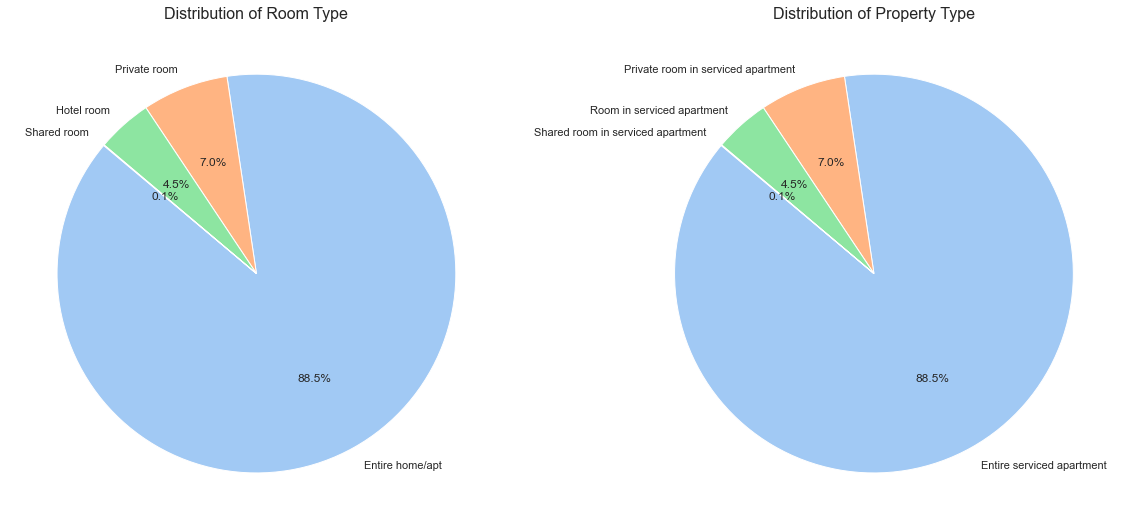

                 Room Type
room_type                 
Entire home/apt       1758
Private room           139
Hotel room              89
Shared room              1
                                    Property Type
property_type                                    
Entire serviced apartment                    1758
Private room in serviced apartment            139
Room in serviced apartment                     89
Shared room in serviced apartment               1


In [29]:
# Create a pastel color palette
colors_room_type = sns.color_palette("pastel", len(room_type_counts))
colors_property_type = sns.color_palette("pastel", len(property_type_counts))

# Function to format the labels with percentage
def func(pct):
    return "{:.1f}%".format(pct)

# Plot pie chart for room type
plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
plt.pie(room_type_counts, labels=room_type_counts.index, autopct=func, startangle=140, colors=colors_room_type)
plt.title('Distribution of Room Type', fontsize=16)

# Plot pie chart for property type
plt.subplot(1, 2, 2)
plt.pie(property_type_counts, labels=property_type_counts.index, autopct=func, startangle=140, colors=colors_property_type)
plt.title('Distribution of Property Type', fontsize=16)

plt.tight_layout()
plt.show()

# Summary counts as DataFrame for room types
room_type_summary_df = pd.DataFrame({
    'Room Type': room_type_counts
}).astype(int)

# Summary counts as DataFrame for property types
property_type_summary_df = pd.DataFrame({
    'Property Type': property_type_counts
}).astype(int)

print(room_type_summary_df)
print(property_type_summary_df)

#### Definition
**Entire serviced apartment:** Exclusive use of the entire apartment with hotel-like services.

**Private room in serviced apartment:** Private bedroom within a serviced apartment, shared common areas, includes services.

**Room in serviced apartment:** Similar to "Private room in serviced apartment," emphasizes a private room with shared common areas and services.

**Shared room in serviced apartment:** Shared sleeping quarters and common areas within a serviced apartment, includes services.

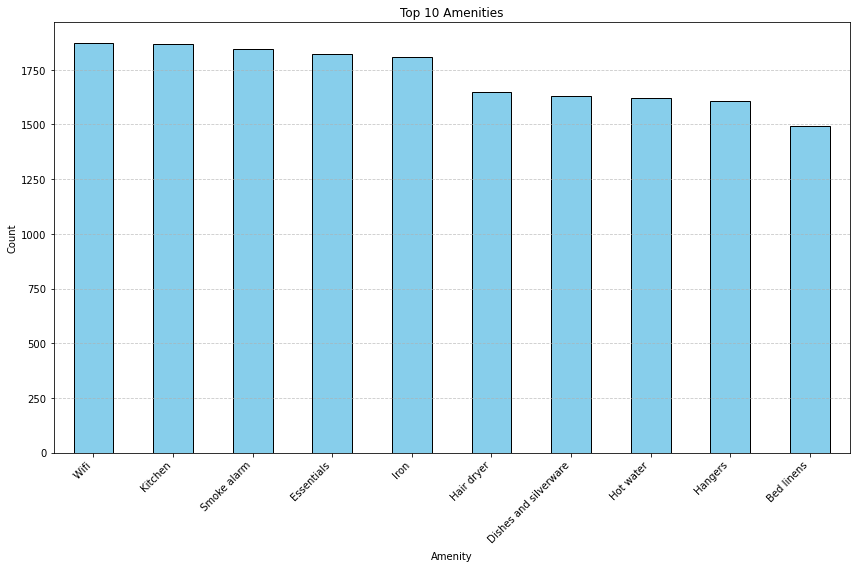

In [35]:
# Make a copy of the dataframe to avoid modifying the original
apartment_df_amenities = apartment_df_cleaned.copy()

# Preprocess the amenities data
# Remove leading/trailing spaces and brackets
apartment_df_amenities['amenities'] = apartment_df_amenities['amenities'].str.replace('[{}"]', '',regex=True).str.strip()

# Split the amenities into individual items
all_amenities = apartment_df_amenities['amenities'].str.split(',')

# Count the occurrences of each amenity
amenity_counts = all_amenities.explode().value_counts()

# Get the top 10 amenities
top_10_amenities = amenity_counts.head(10)

# Plot the top 10 amenities
plt.figure(figsize=(12, 8))
top_10_amenities.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Top 10 Amenities')
plt.xlabel('Amenity')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

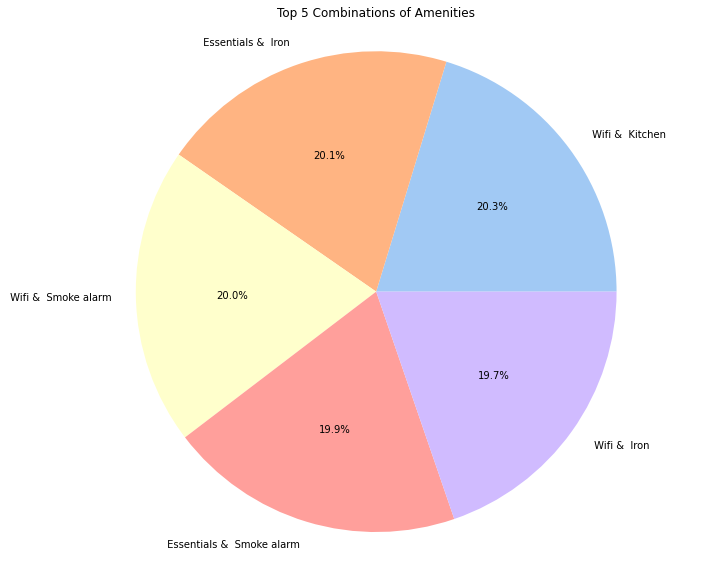

In [38]:
# Convert to DataFrame for visualization
combinations_df = pd.DataFrame(top_5_combinations, columns=['Combination', 'Count'])
combinations_df['Combination'] = combinations_df['Combination'].apply(lambda x: ' & '.join(x))

# Define a pastel color palette and replace green with yellow
pastel_colors = sns.color_palette('pastel')
# Replace green (index 2 in the default pastel palette) with a pastel yellow
custom_colors = pastel_colors[:2] + [(1.0, 1.0, 0.8)] + pastel_colors[3:]

# Plot the top 5 combinations of amenities as a pie chart
plt.figure(figsize=(10, 8))
plt.pie(combinations_df['Count'], labels=combinations_df['Combination'], autopct='%1.1f%%', colors=custom_colors)
plt.title('Top 5 Combinations of Amenities')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.tight_layout()
plt.show()

In [34]:
# Make a copy of the dataframe to avoid modifying the original
apartment_df_copy = apartment_df_cleaned.copy()

# Prepare the data
# Ensure that latitude, longitude, and review_scores_rating columns exist
apartment_df_copy = apartment_df_copy.dropna(subset=['latitude', 'longitude', 'review_scores_rating'])

# Create a base map
map_center = [apartment_df_copy['latitude'].mean(), apartment_df_copy['longitude'].mean()]
m = folium.Map(location=map_center, zoom_start=12)

# Add a marker cluster to the map
marker_cluster = MarkerCluster().add_to(m)

# Function to color-code the markers based on review scores
def get_color(rating):
    if rating >= 4.5:
        return 'green'
    elif rating >= 3.5:
        return 'orange'
    else:
        return 'red'

# Add markers to the map
for idx, row in apartment_df_copy.iterrows():
    folium.CircleMarker(
        location=(row['latitude'], row['longitude']),
        radius=5,
        color=get_color(row['review_scores_rating']),
        fill=True,
        fill_color=get_color(row['review_scores_rating']),
        fill_opacity=0.7,
        popup=folium.Popup(f"Rating: {row['review_scores_rating']}")
    ).add_to(marker_cluster)

# Save the map to an HTML file
m.save('review_scores_map.html')

## Numeric - Categorical Analysis (Price VS other attributes)

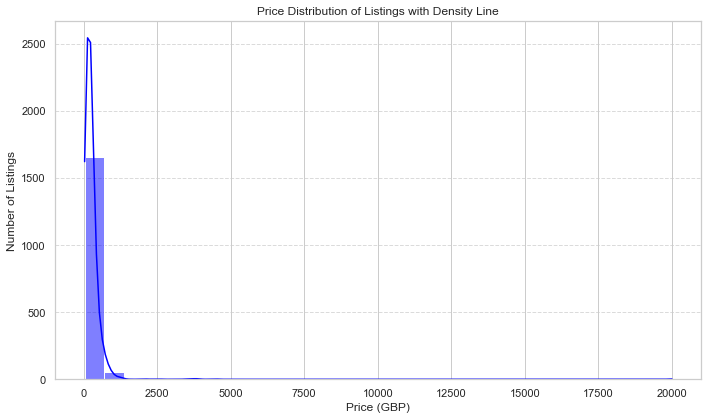

In [13]:
# Make a copy of the dataframe to avoid modifying the original
apartment_df_copy_pricedist = apartment_df_cleaned.copy()

# Convert the price column to numeric (remove any currency symbols and commas)
apartment_df_copy_pricedist['price'] = apartment_df_copy_pricedist['price'].replace('[\$,]', '', regex=True).astype(float)

# Plot the price histogram with a density line
plt.figure(figsize=(10, 6))
sns.histplot(apartment_df_copy_pricedist['price'].dropna(), bins=30, kde=True, color='blue')
plt.title('Price Distribution of Listings with Density Line')
plt.xlabel('Price (GBP)')
plt.ylabel('Number of Listings')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

With this information, we can see that the prices are skewed to the right, and some outliers lie above approximately ~ **$2435.39** (percentile 99.7)

**Skewness:** The histogram shows that the price distribution is heavily skewed to the right. This means that while most listings are clustered around lower price ranges, there are some listings with very high prices that extend the tail to the right.

**Outlier:** Listings with prices above approximately £2435.39 are considered outliers, as they fall beyond the 99.7th percentile.

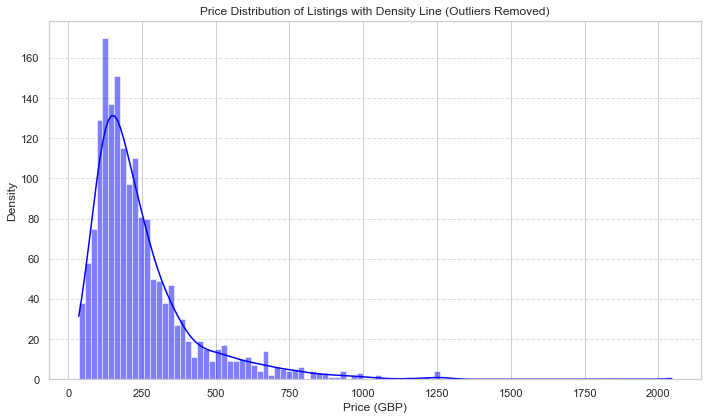

In [15]:
# Drop rows with NaN values in the 'price' column
apartment_df_copy_pricedist_1 = apartment_df_copy_pricedist.dropna(subset=['price'])

# Remove outliers above the 99.7th percentile
percentile_997 = apartment_df_copy_pricedist_1['price'].quantile(0.997)
apartment_df_copy_pricedist = apartment_df_copy_pricedist_1[apartment_df_copy_pricedist_1['price'] <= percentile_997]

# Plot the price histogram with a density line
plt.figure(figsize=(10, 6))
sns.histplot(apartment_df_copy_pricedist_1['price'], bins=100, kde=True, color='blue')
plt.title('Price Distribution of Listings with Density Line (Outliers Removed)')
plt.xlabel('Price (GBP)')
plt.ylabel('Density')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### Boxplot of the price according to neighbouthood in London

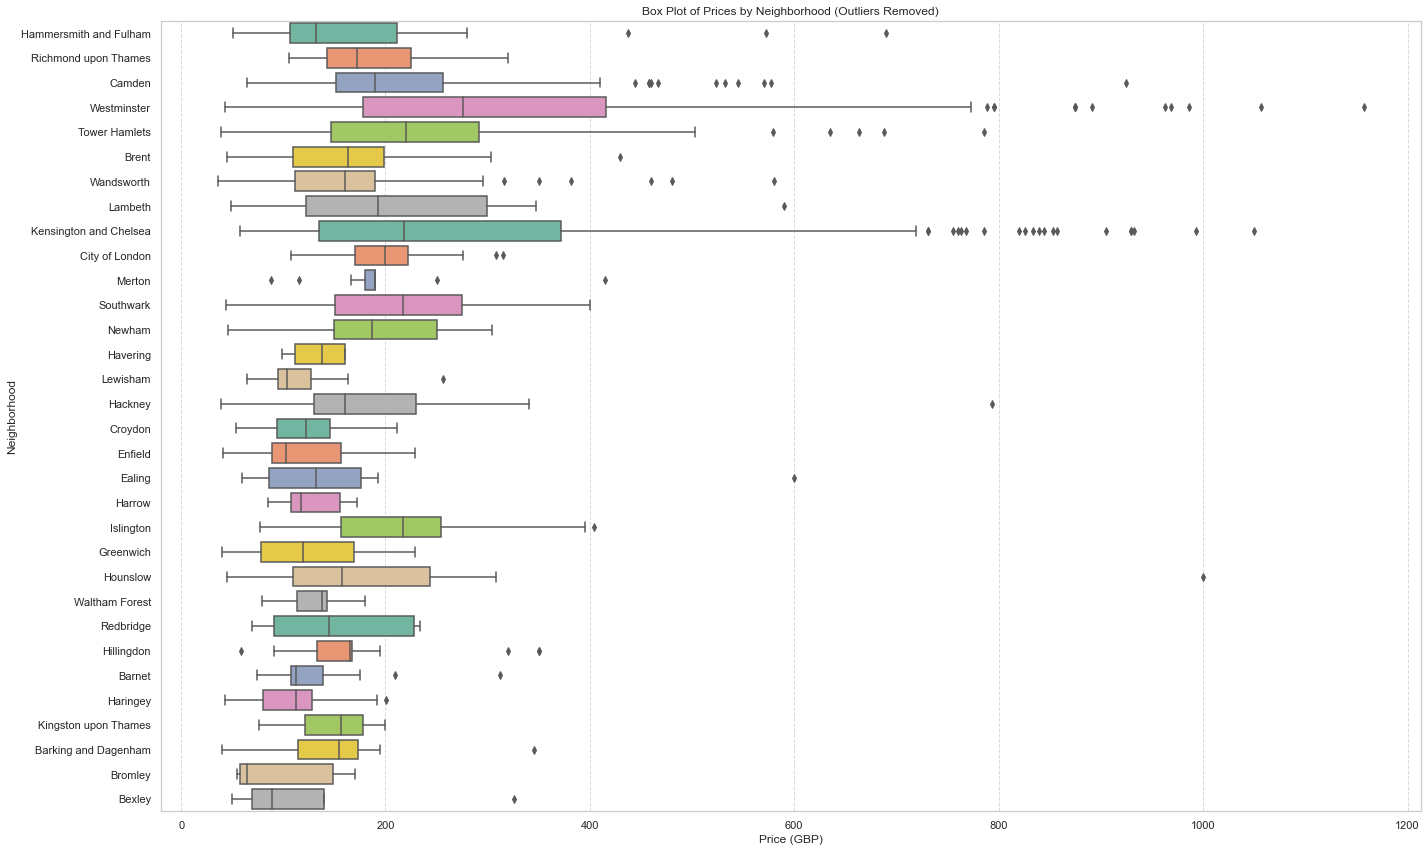

In [17]:
# Remove outliers where price > 300 GBP
filtered_df = apartment_df_copy_pricedist_1[apartment_df_copy_pricedist_1['price'] <= percentile_997]

# Plot the box plot of price according to neighborhood
plt.figure(figsize=(20, 12))
sns.boxplot(x=filtered_df['price'], y=filtered_df['neighbourhood_cleansed'], orient='h', palette='Set2')
plt.title('Box Plot of Prices by Neighborhood (Outliers Removed)')
plt.xlabel('Price (GBP)')
plt.ylabel('Neighborhood')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Kensignton and Chelsea and Westminster, has the highest prices considering the IQR [25%-75%].

### Boxplot of the price according to property type

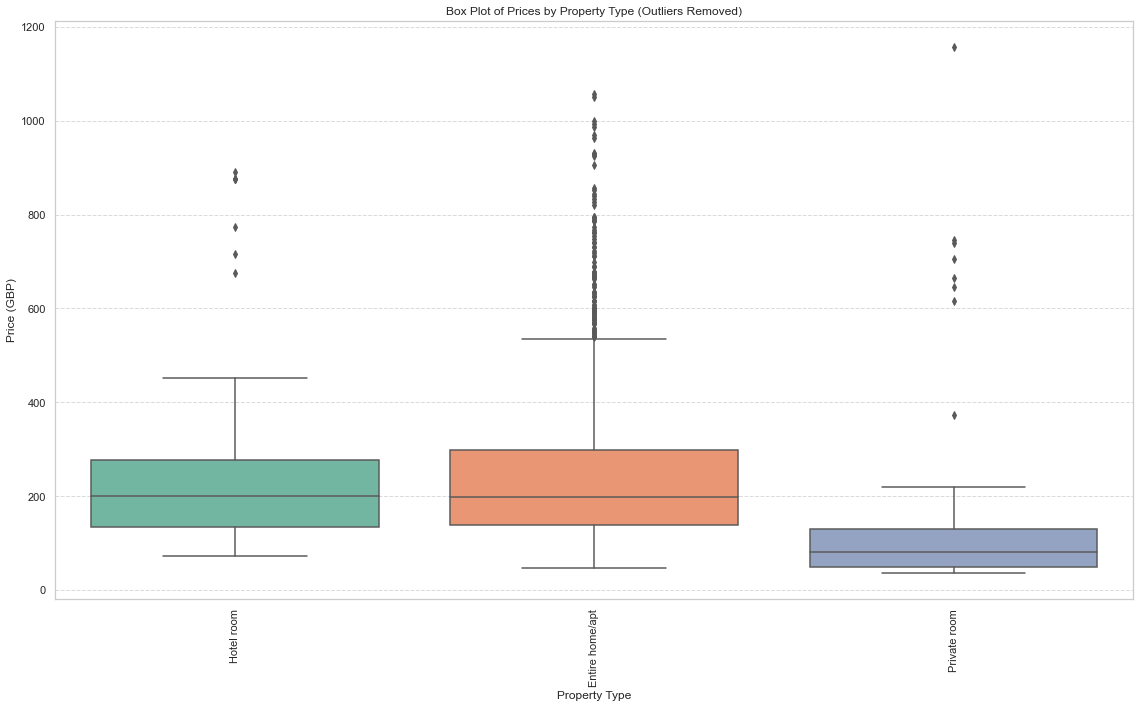

In [18]:
# Plot the box plot of price according to property type
plt.figure(figsize=(16, 10))
sns.boxplot(x=filtered_df['room_type'], y=filtered_df['price'], palette='Set2')
plt.title('Box Plot of Prices by Room Type (Outliers Removed)')
plt.xlabel('Property Type')
plt.ylabel('Price (GBP)')
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

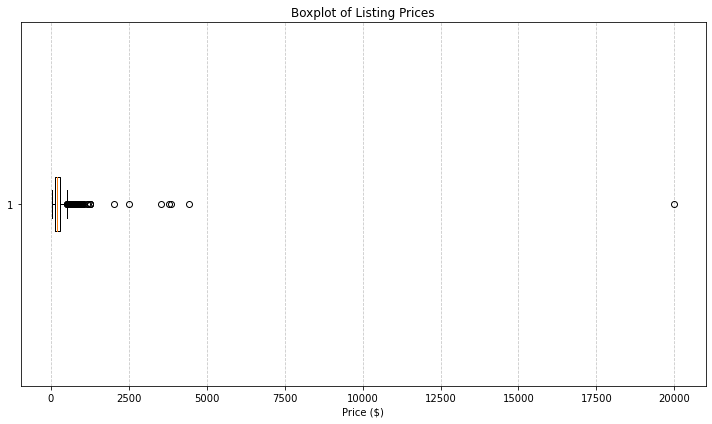

In [29]:
# Make a copy of the dataframe to avoid modifying the original
apartment_df_copy = apartment_df_cleaned.copy()

# Convert the price column to numeric (remove any currency symbols and commas)
apartment_df_copy['price'] = apartment_df_copy['price'].replace('[\$,]', '', regex=True).astype(float)

# Plot the price boxplot
plt.figure(figsize=(10, 6))
plt.boxplot(apartment_df_copy['price'].dropna(), vert=False)
plt.title('Boxplot of Listing Prices')
plt.xlabel('Price ($)')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()